# DEPENDANCIES AND LIBRARIES

In [2]:
import os
import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib, os, random
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions



from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# DATA SET

In [7]:
#print the directory
os.listdir('C:/Users/ASUS/Documents/FISH-DATASET/FishImgDataset')

['test', 'train', 'val']

In [9]:
train = 'C:/Users/ASUS/Documents/FISH-DATASET/FishImgDataset/train' #training path
validation = 'C:/Users/ASUS/Documents/FISH-DATASET/FishImgDataset/val' #validation path
test = 'C:/Users/ASUS/Documents/FISH-DATASET/FishImgDataset/test' #test path

In [10]:
#DATA AUGMENTATION
train_datagen = ImageDataGenerator(rescale = 1./255, #convert to target values between 0 and 1 for faster training
                                   shear_range = 0.2, #for randomly applying shearing transformations 
                                   zoom_range = 0.2,  # for randomly zooming inside pictures
                                   horizontal_flip = True)#for randomly flipping half of the images horizontally)#initialize train generator 
valid_datagen = ImageDataGenerator(rescale = 1.0/255.) #initialize validation generator 
test_datagen = ImageDataGenerator(rescale = 1.0/255.) #initialize validation generator 

In [11]:
#flow_from_directory it take the path to a directory & generates batches of augmented data.
#target_size the dimensions to which all images found will be resized
#batch_size the size of the batches of data (default: 32)
#class_mode determines the type of label arrays that are returned("categorical" for 2D labels,"binary" for 1D binary labels,"sparse" for 1D integer labels,and "input" for identical image
#shuffle use whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.

train_generator = train_datagen.flow_from_directory(train, target_size=(224,224),batch_size=32,class_mode='categorical')
validation_generator = valid_datagen.flow_from_directory(validation, target_size=(224,224),batch_size=32,class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test, target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=False)

Found 8650 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1901 images belonging to 31 classes.


# INCEPTION MODEL DECLARATION

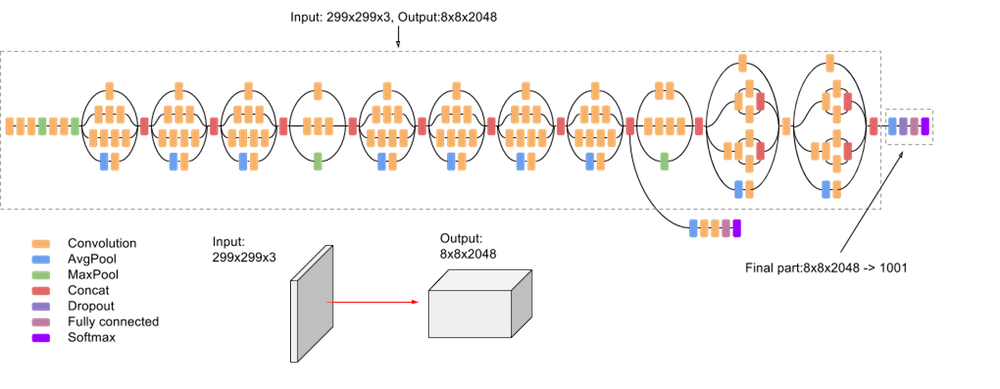

In [12]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))
#inception.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 684s 8us/step


In [13]:
inception.trainable = True
for layer in inception.layers[:197]:
    layer.trainable = False 

In [21]:
for idx, layer in enumerate(inception.layers):
    print(f' {idx}:  {layer.name}: trainable = {layer.trainable}')

 0:  input_layer: trainable = False
 1:  conv2d: trainable = False
 2:  batch_normalization: trainable = False
 3:  activation: trainable = False
 4:  conv2d_1: trainable = False
 5:  batch_normalization_1: trainable = False
 6:  activation_1: trainable = False
 7:  conv2d_2: trainable = False
 8:  batch_normalization_2: trainable = False
 9:  activation_2: trainable = False
 10:  max_pooling2d: trainable = False
 11:  conv2d_3: trainable = False
 12:  batch_normalization_3: trainable = False
 13:  activation_3: trainable = False
 14:  conv2d_4: trainable = False
 15:  batch_normalization_4: trainable = False
 16:  activation_4: trainable = False
 17:  max_pooling2d_1: trainable = False
 18:  conv2d_8: trainable = False
 19:  batch_normalization_8: trainable = False
 20:  activation_8: trainable = False
 21:  conv2d_6: trainable = False
 22:  conv2d_9: trainable = False
 23:  batch_normalization_6: trainable = False
 24:  batch_normalization_9: trainable = False
 25:  activation_6: tra

In [27]:
# Get the layer by name
last_layer = inception.get_layer('mixed7')

# Get the output of the last layer
layer_output = last_layer.output

# Print the shape of the layer output
print('last layer output shape: ', layer_output.shape)


last layer output shape:  (None, 12, 12, 768)


In [28]:
n_categories = len(os.listdir('C:/Users/ASUS/Documents/FISH-DATASET/FishImgDataset/train'))# number of categories
print(n_categories)

31


# Model Modification

In [29]:
# x  = BatchNormalization()(layer_output)
xs = Flatten()(layer_output)
xs = Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(xs)
xs = Dropout(0.4)(xs)
xs = Dense(n_categories, activation='softmax')(xs)

model = Model(inputs=inception.inputs, outputs=xs)

# Compiling Model

In [30]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# CALLBACKS

In [31]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# MODEL FITTING

In [32]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 10, #10
            callbacks=[callback])

Epoch 1/10


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


243/271 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.5047 - loss: 3.9065

KeyboardInterrupt: 

# LOSS AND VALIDATION LOSS

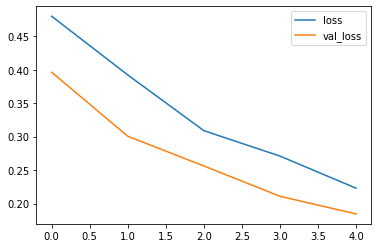

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# ACCURACY AND VALIDATION ACCURACY

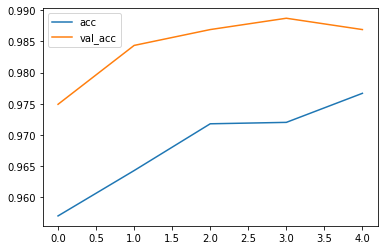

In [24]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

# Saving of model Classfier

In [25]:
model_name = 'FishModelClassifier_V6.h5'
model.save(model_name, save_format='h5')
model.save_weights('model_weights_V6.h5')

# Accuracy of the model classifier in a new data

In [26]:
results = model.evaluate(test_generator, verbose=0)


print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.22477
Test Accuracy: 97.50%


# Prediction of new data w/ Image

In [ ]:

class_name=['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin',
        'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer',
        'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish',
        'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp',
        'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']

images, labels = test_generator.next()
preds = model.predict(images)
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(25,25))
dic={i:ax for i,ax in enumerate(axes.flat)}
for i in range(0,8):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title("real label: " + str(class_name[label]) + " v.s " + "predictedd lable: " + str(class_name[pred]))
    dic[i].imshow(image)
plt.tight_layout()    
plt.show() 

# Prediction of a new data

2022-10-19 18:41:28.072991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Mudfish: 85.99%
Snakehead: 7.03%
Goby: 5.21%
Long-Snouted Pipefish: 0.60%
Janitor Fish: 0.46%
Mudfish


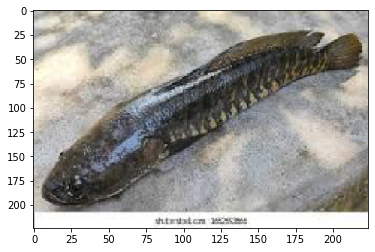

In [7]:
from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array
import numpy as np

model = load_model('./FishModelClassifier.h5',compile=False)
class_name=['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin',
        'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer',
        'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish',
        'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp',
        'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


def predict(path):
    img=load_img(path,target_size=(224,224,3))#convert image size and declare the kernel
    img=img_to_array(img)#convert the image to an image array
    img=img/255 #rgb is 255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    x = list(np.argsort(answer[0])[::-1][:5])
    
    for i in x:
        print("{className}: {predVal:.2f}%".format(className=class_name[i], predVal=float(answer[0][i])*100))
    
    y_class=answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = class_name[y]
    
    return res

img='../input/fish-dataset/FishImgDataset/test/Mudfish/Mudfish 013.jpg'
print(predict(img))

img=load_img(img,target_size=(224,224,3))
plt.imshow(img, aspect="auto")

# Visualize Feature Maps

In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Get list of layers from model
layer_outputs = [layer.output for layer in model.layers[1:]]
# Create a visualization model
visualize_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)


In [42]:
# Load image for prediction
img=load_img('../input/fish-dataset/FishImgDataset/test/Mudfish/Mudfish 013.jpg',target_size=(224,224))
# Convert image to array
x = img_to_array(img)
# Print shape of array
x.shape

# Reshape image for passing it to prediction
x=x.reshape((1,224,224,3))
print(x.shape)
# Rescale the image
x = x /255 

# Get all layers feature maps for image
feature_maps=visualize_model.predict(x)
print(len(feature_maps))
# Show names of layers available in model
layer_names = [layer.name for layer in model.layers]

(1, 224, 224, 3)
232


(1, 111, 111, 32)
(1, 111, 111, 32)
(1, 111, 111, 32)
(1, 109, 109, 32)
(1, 109, 109, 32)
(1, 109, 109, 32)
(1, 109, 109, 64)
(1, 109, 109, 64)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(1, 109, 109, 64)
(1, 54, 54, 64)
(1, 54, 54, 80)
(1, 54, 54, 80)
(1, 54, 54, 80)
(1, 52, 52, 192)
(1, 52, 52, 192)
(1, 52, 52, 192)
(1, 25, 25, 192)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 192)
(1, 25, 25, 64)
(1, 25, 25, 64)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(1, 25, 25, 96)
(1, 25, 25, 32)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 32)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 32)
(1, 25, 25, 256)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 256)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 64)
(1, 25, 25, 288)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 48)
(1, 25, 25, 96)
(1, 25, 25, 288)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 64)
(1, 25, 25, 288)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 64)
(1, 25, 25, 96)
(1, 25, 25, 96)
(1,

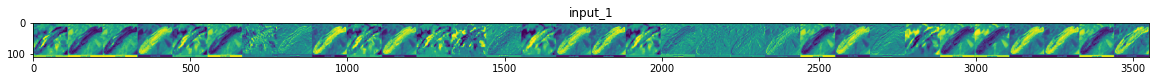

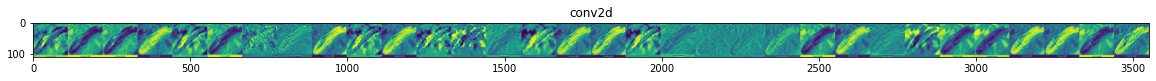

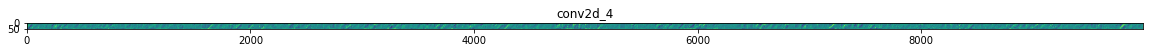

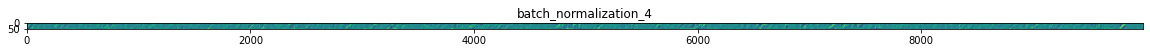

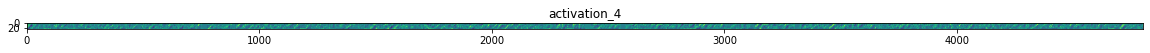

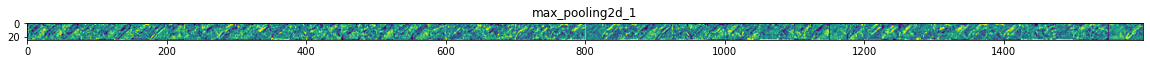

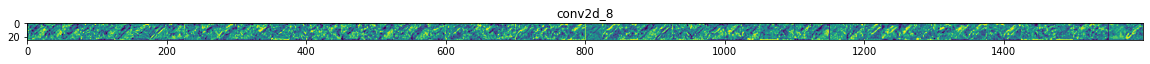

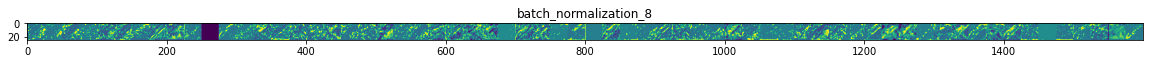

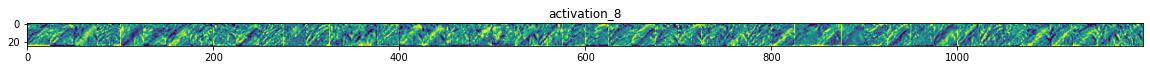

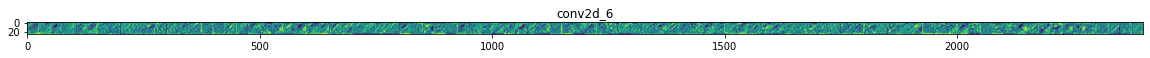

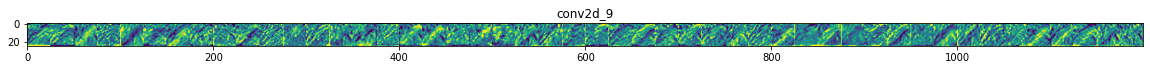

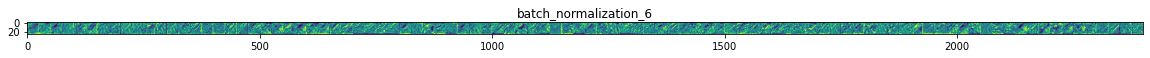

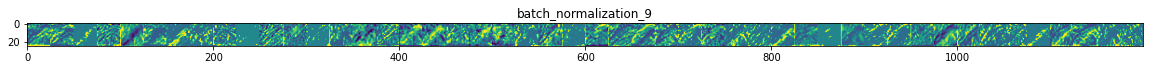

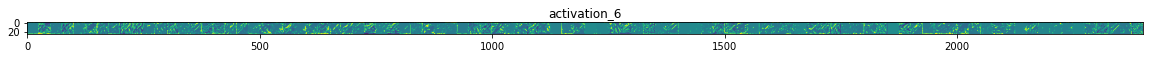

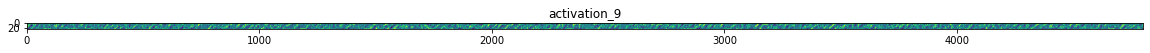

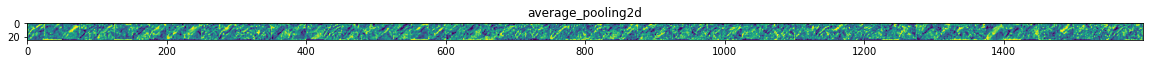

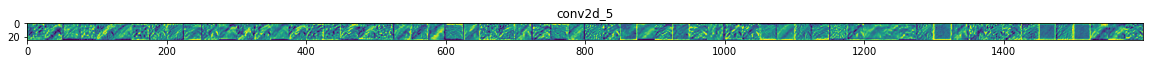

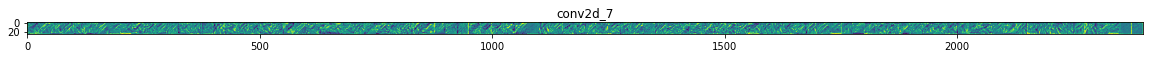

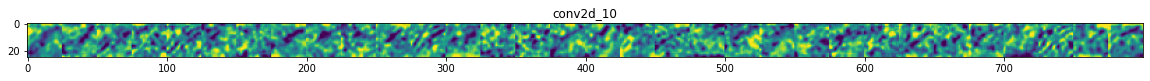

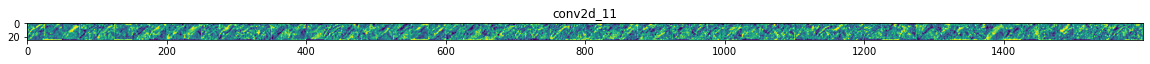

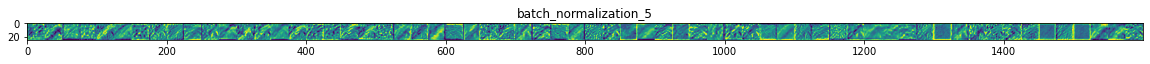

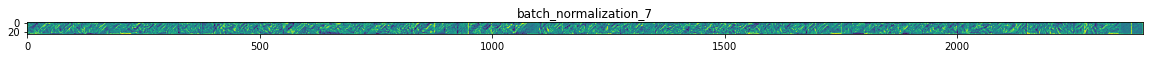

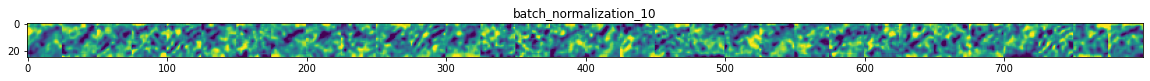

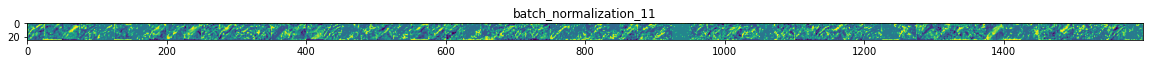

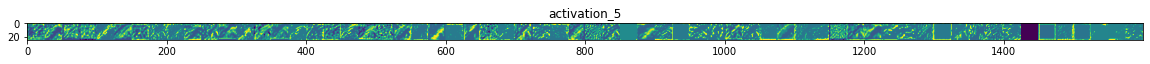

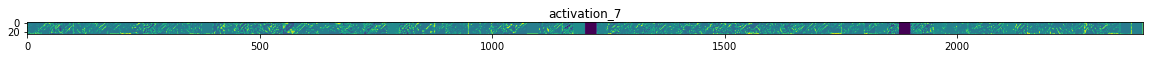

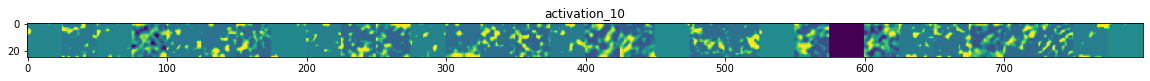

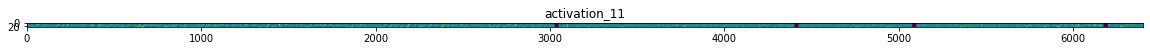

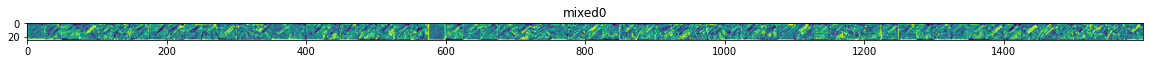

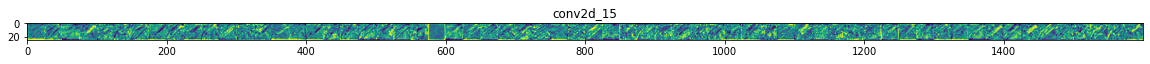

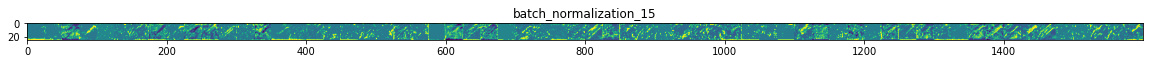

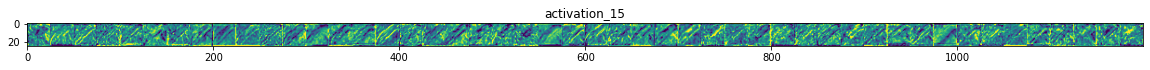

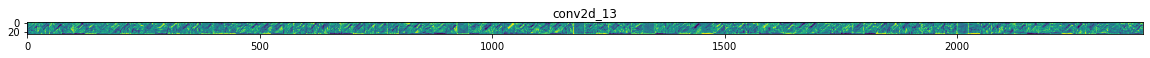

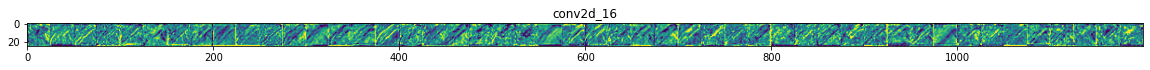

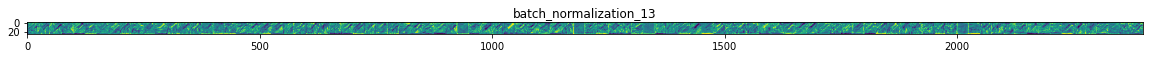

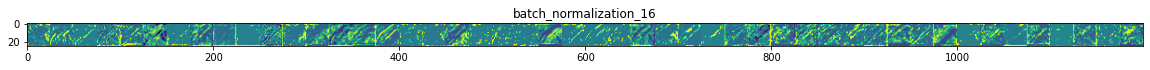

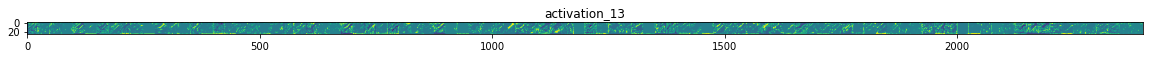

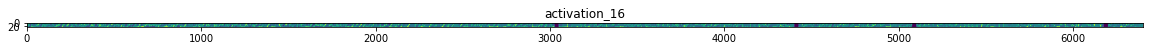

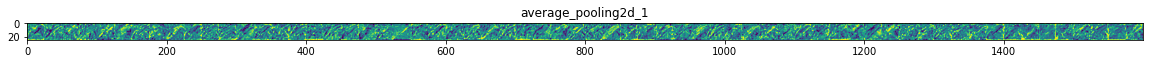

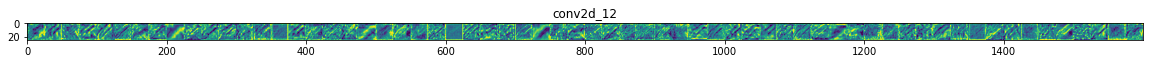

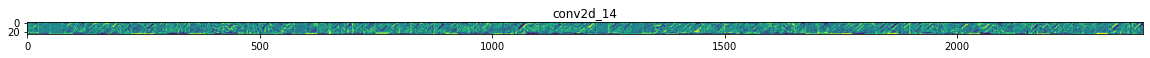

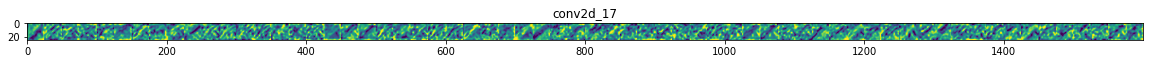

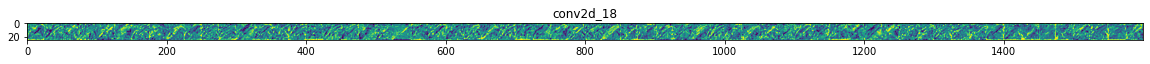

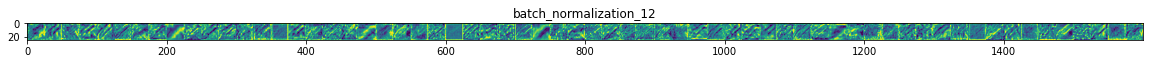

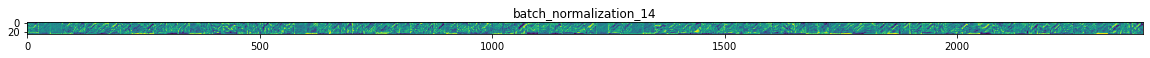

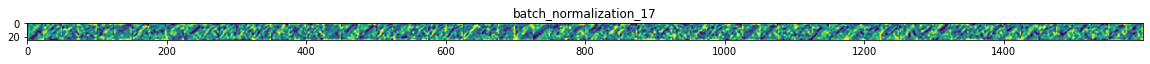

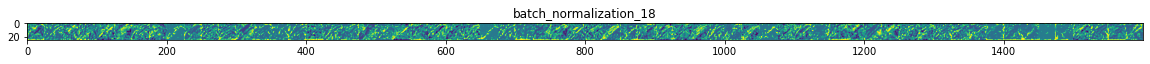

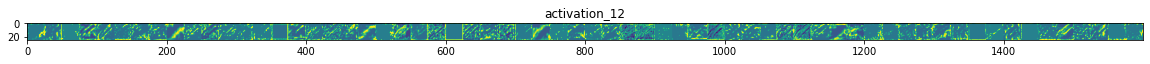

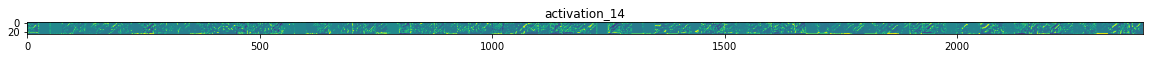

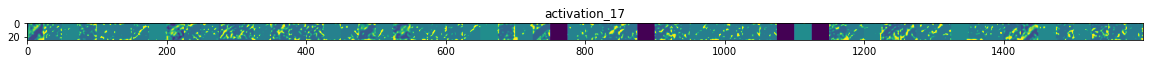

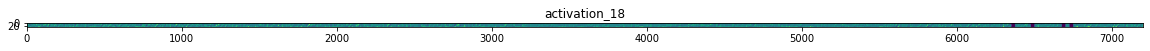

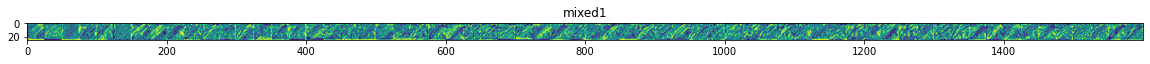

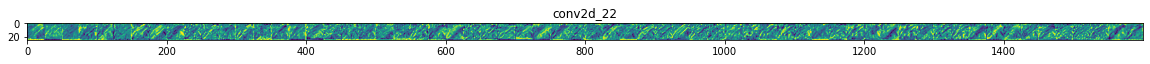

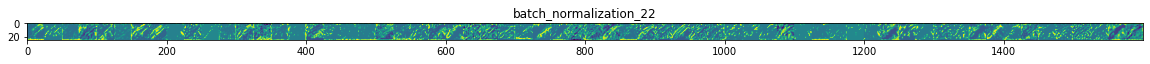

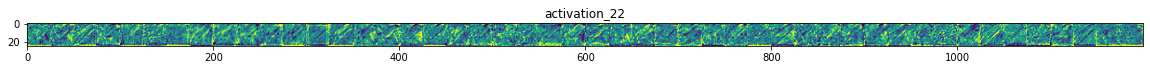

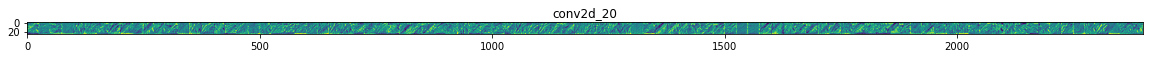

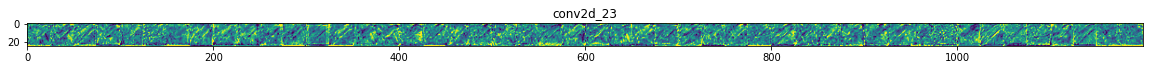

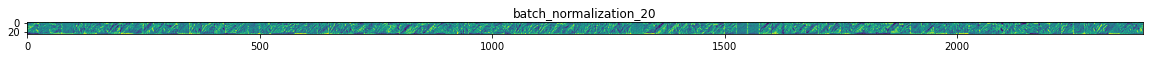

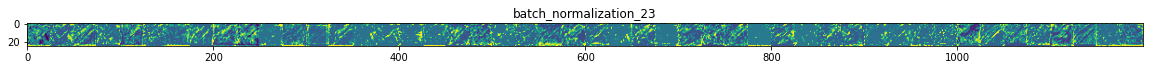

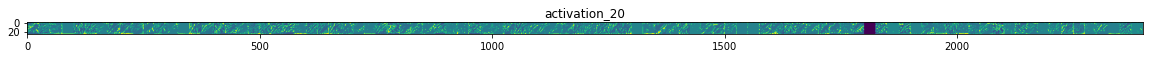

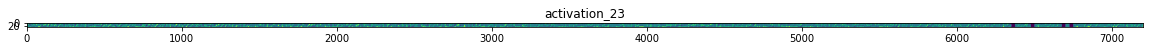

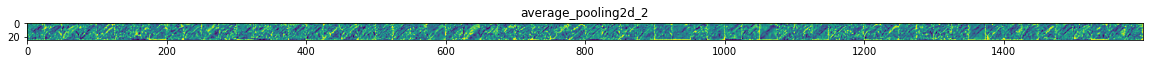

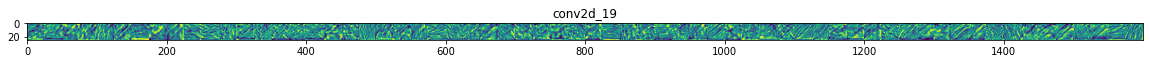

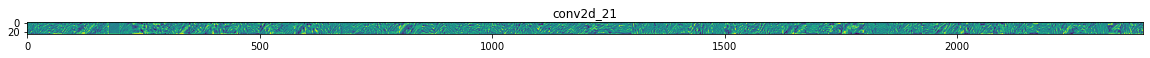

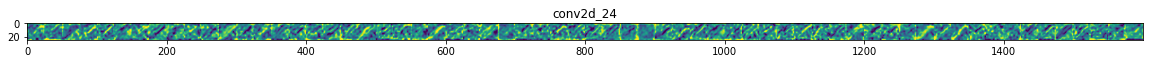

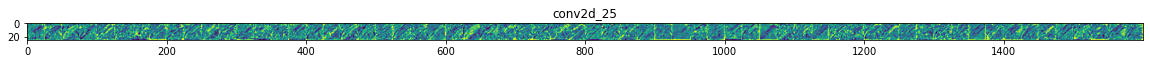

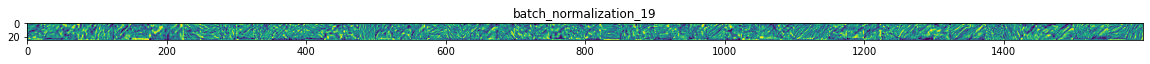

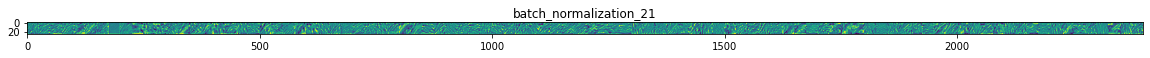

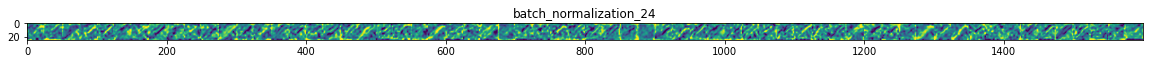

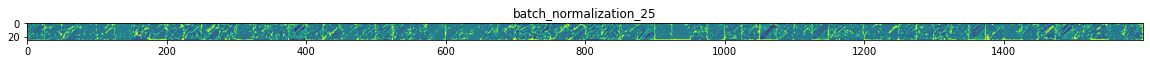

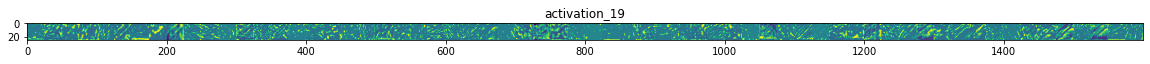

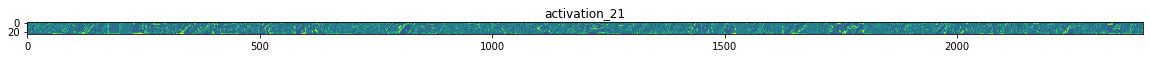

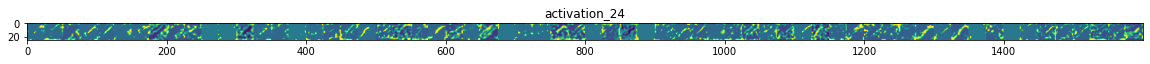

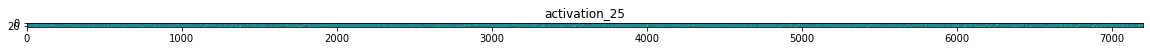

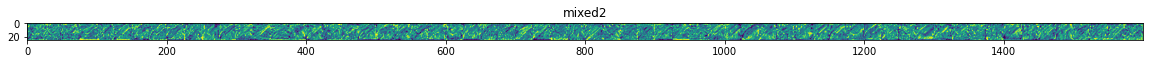

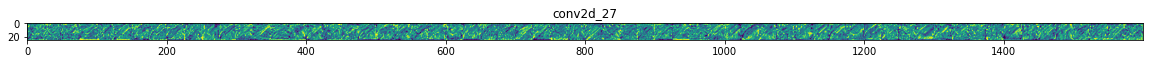

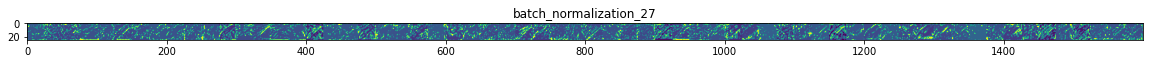

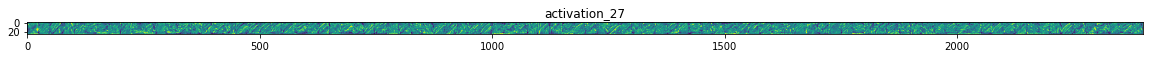

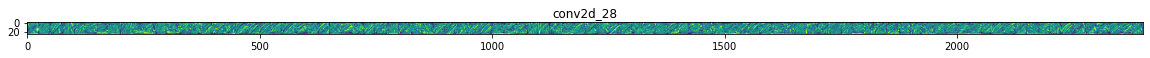

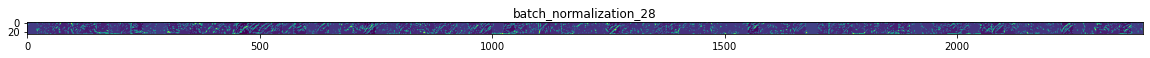

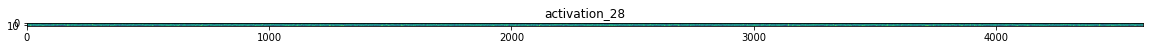

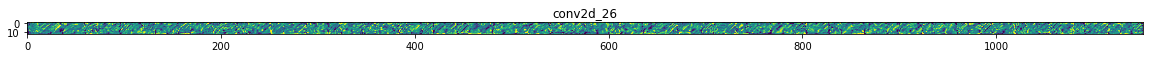

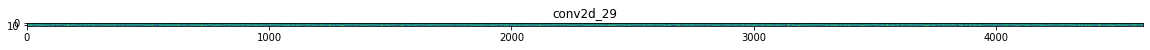

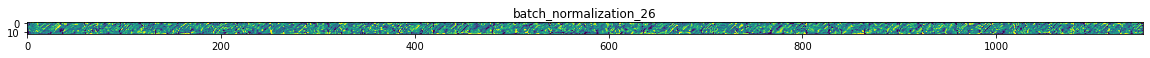

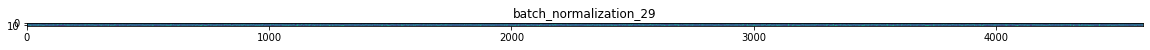

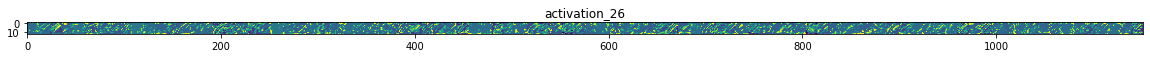

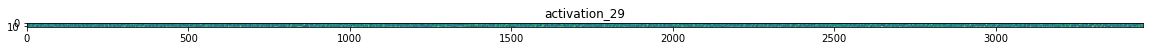

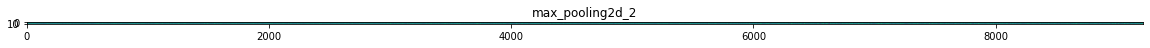

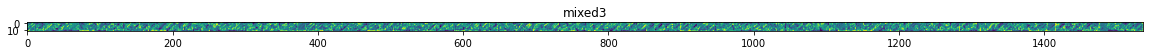

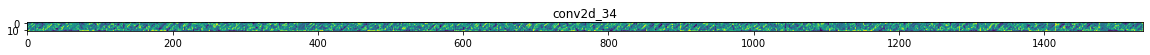

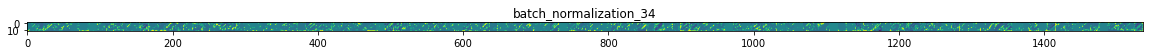

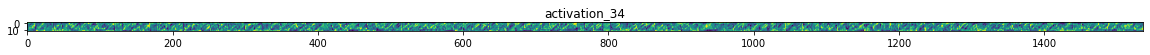

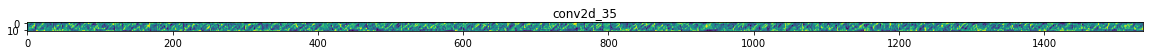

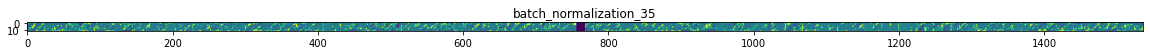

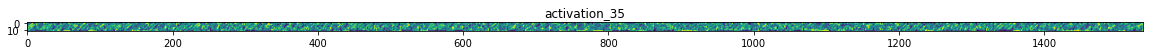

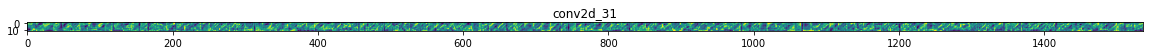

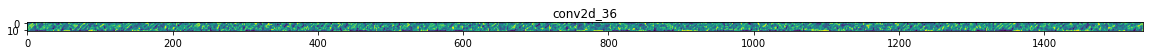

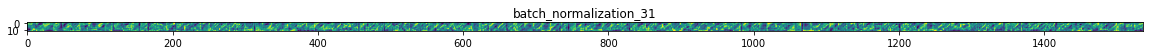

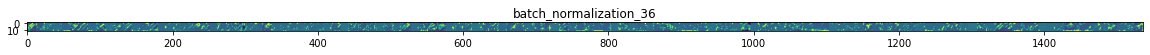

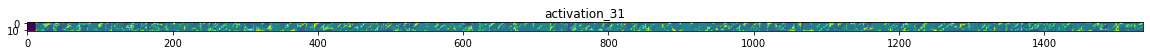

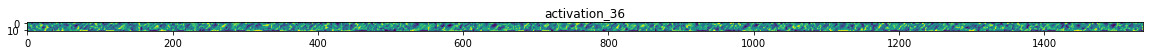

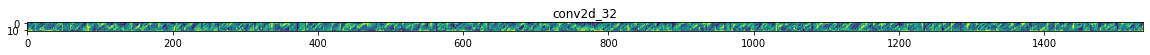

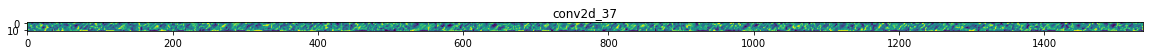

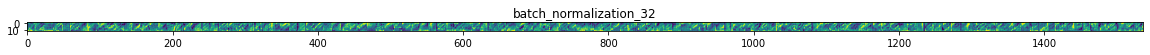

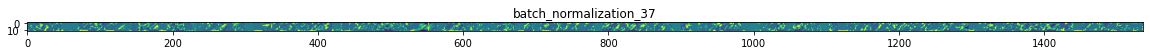

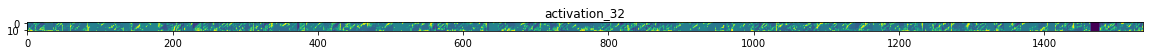

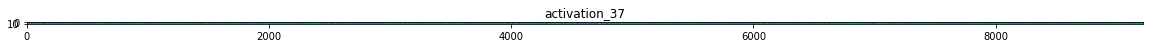

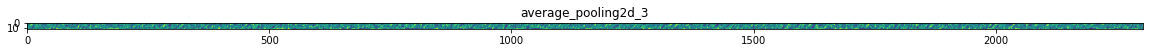

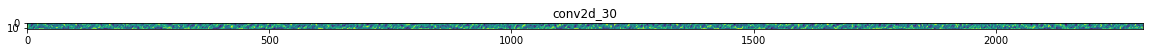

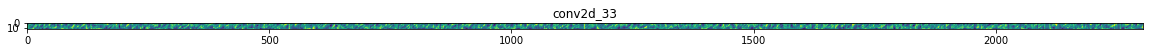

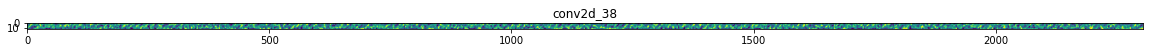

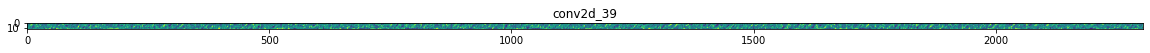

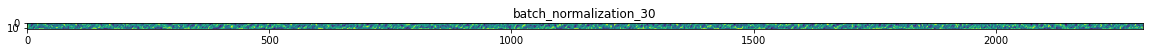

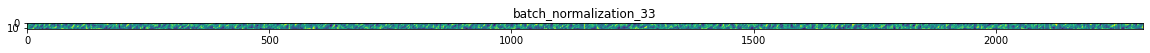

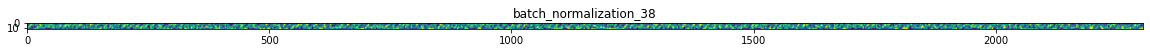

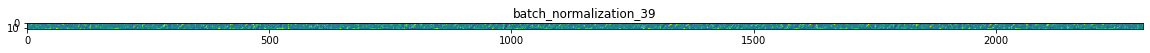

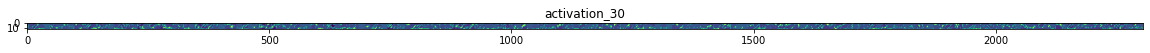

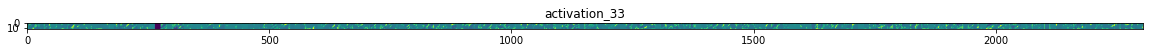

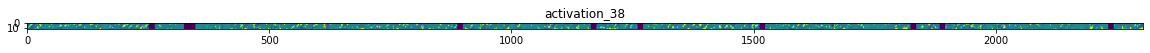

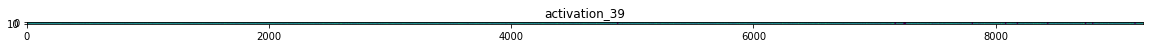

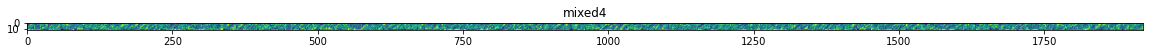

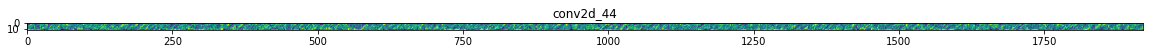

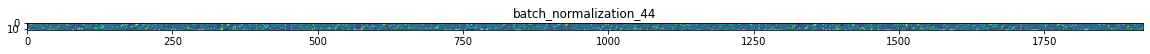

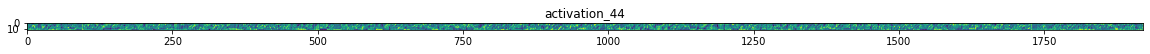

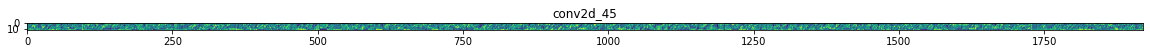

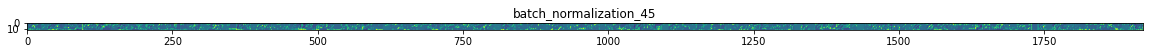

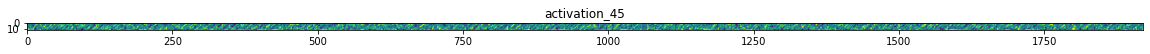

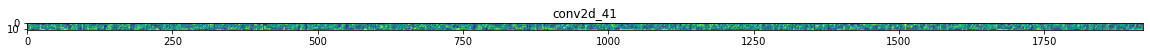

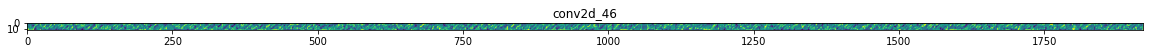

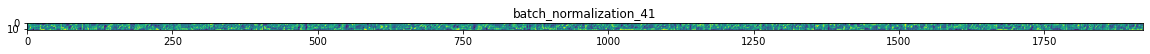

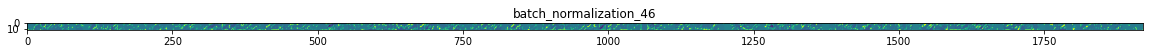

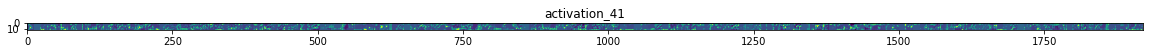

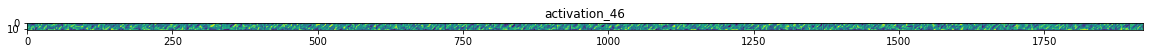

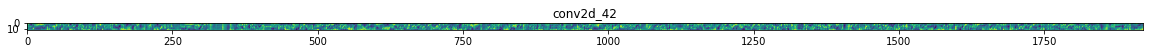

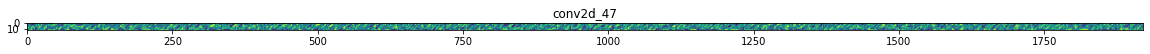

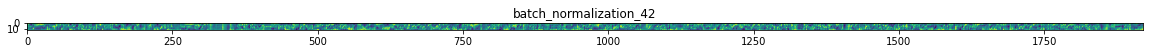

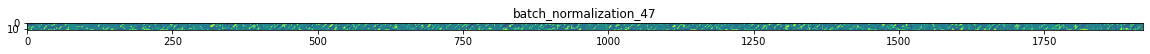

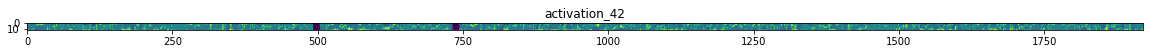

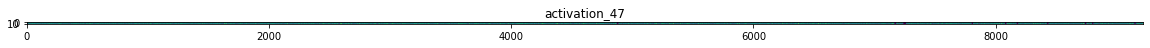

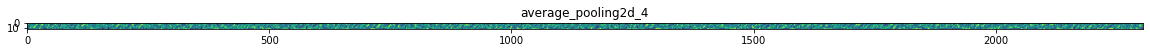

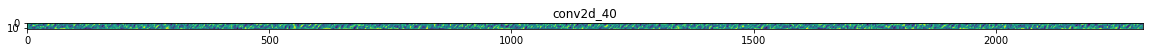

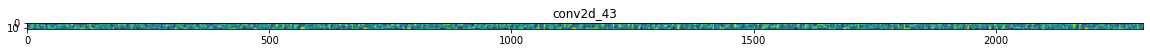

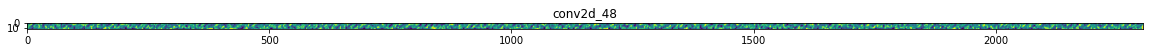

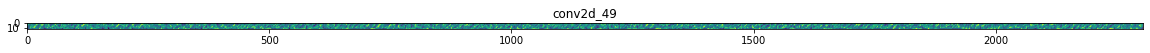

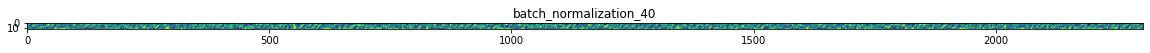

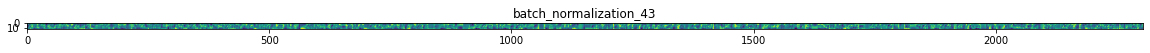

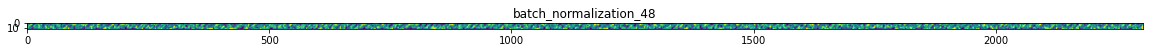

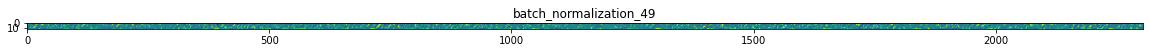

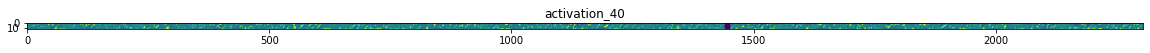

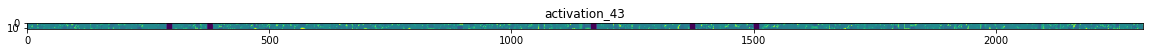

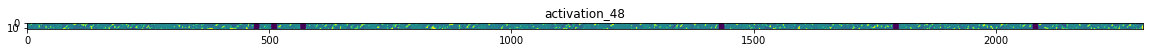

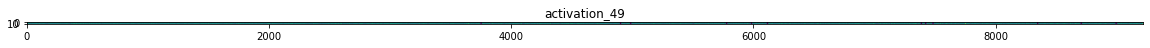

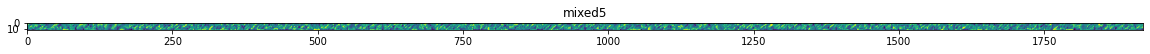

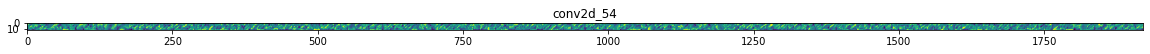

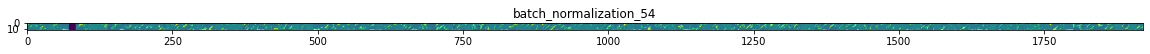

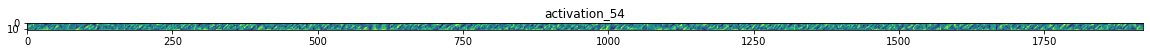

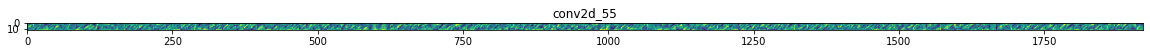

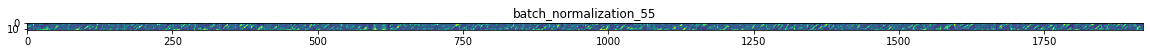

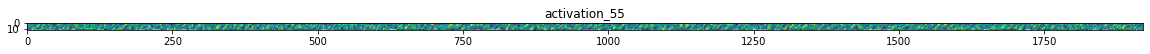

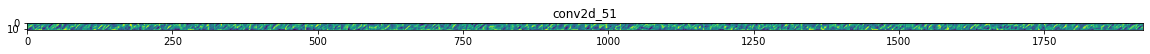

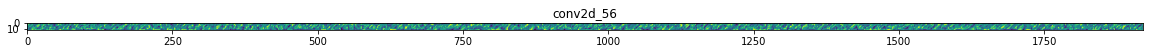

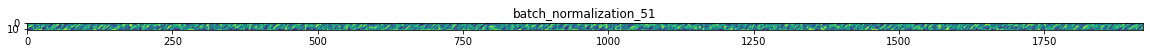

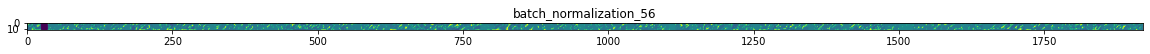

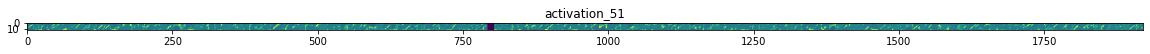

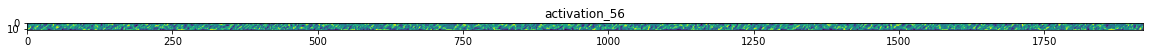

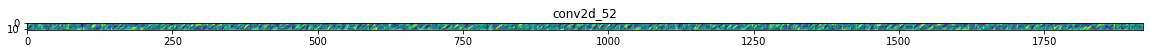

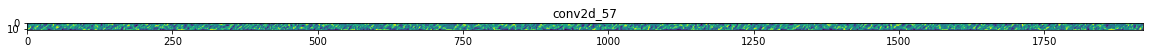

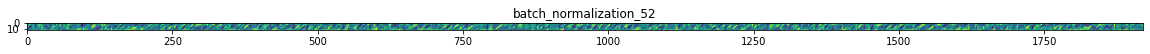

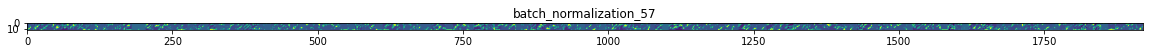

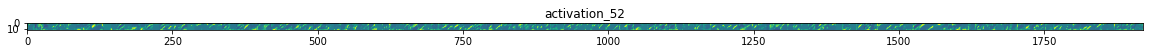

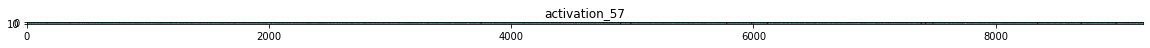

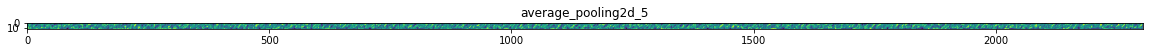

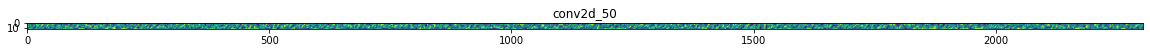

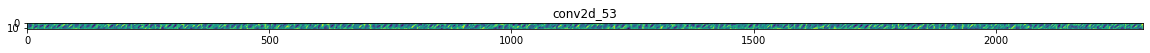

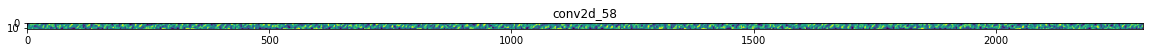

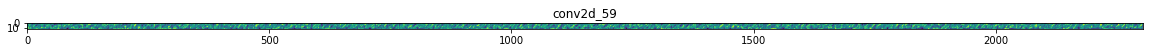

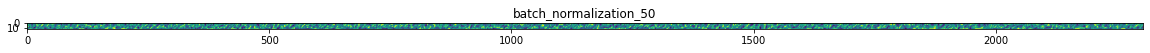

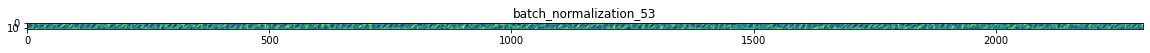

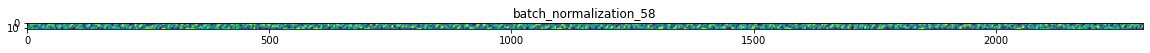

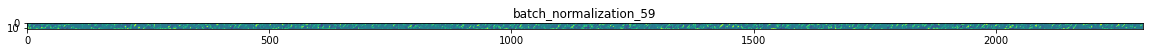

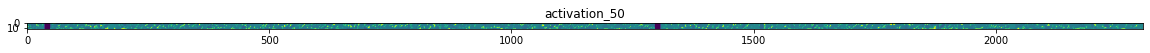

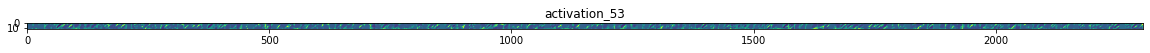

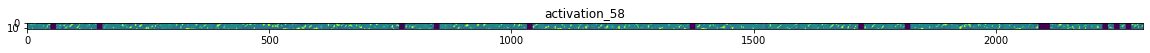

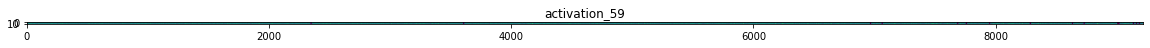

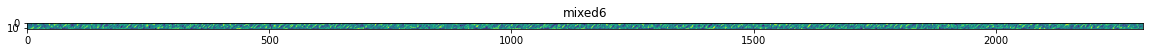

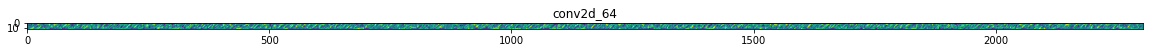

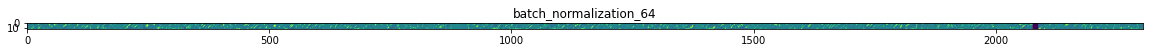

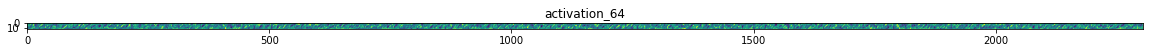

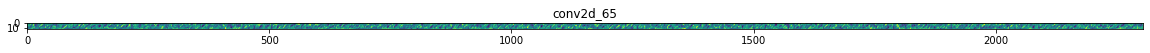

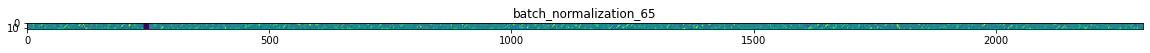

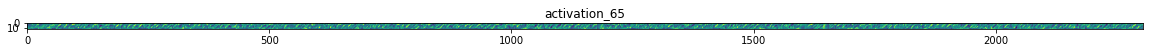

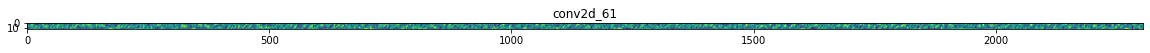

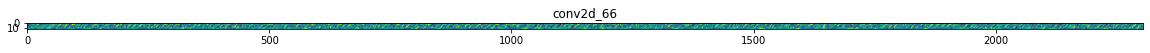

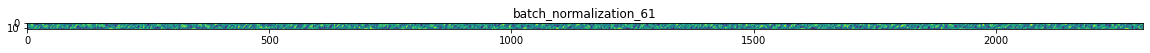

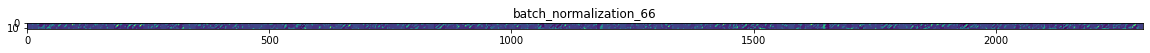

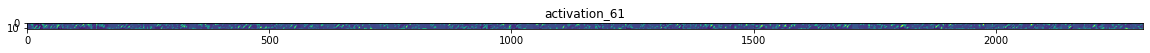

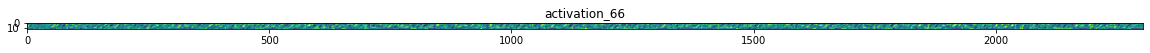

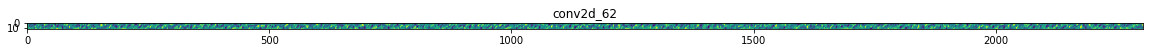

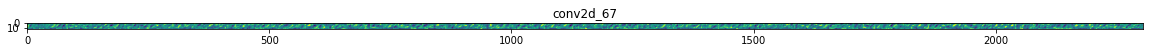

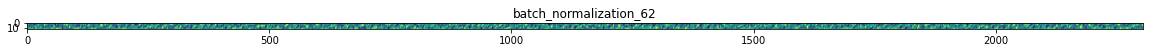

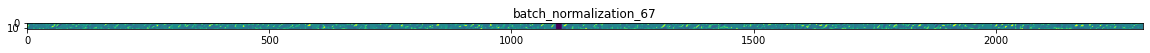

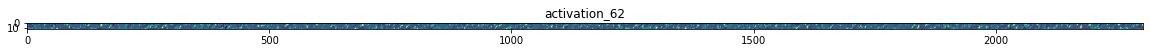

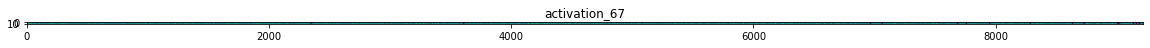

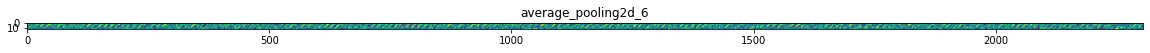

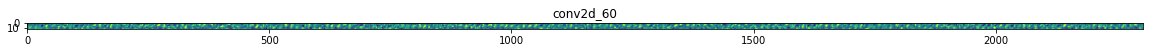

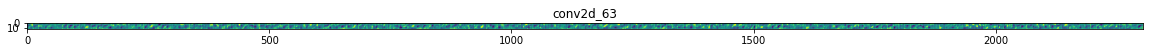

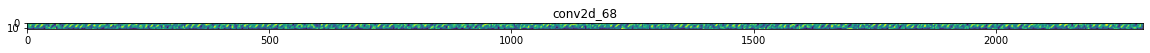

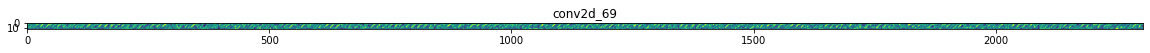

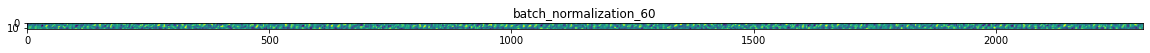

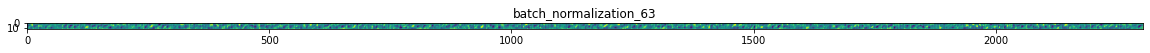

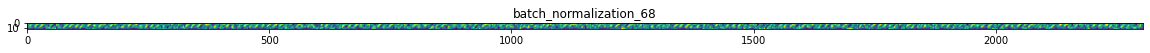

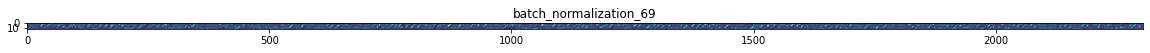

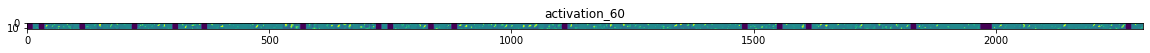

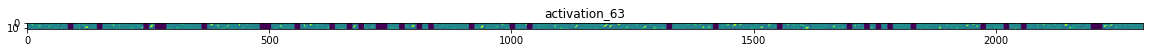

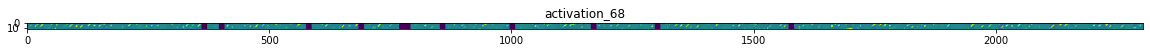

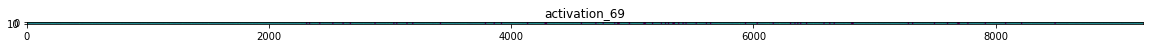

In [43]:
# Plotting the graph
for layer_names, feature_maps in zip(layer_names,feature_maps):
  print(feature_maps.shape)
  if len(feature_maps.shape) == 4 :
    channels = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * channels))
    for i in range(channels):
      x = feature_maps[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / channels
    plt.figure(figsize=(scale * channels, scale))
    plt.title(layer_names)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# CONFUSION MATRIX

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix
Classification Report
                       precision    recall  f1-score   support

               Bangus       0.89      0.97      0.93        34
        Big Head Carp       0.98      1.00      0.99        43
   Black Spotted Barb       0.95      1.00      0.98        40
              Catfish       0.94      0.97      0.95        62
       Climbing Perch       0.90      0.93      0.92        30
 Fourfinger Threadfin       0.97      1.00      0.99        38
       Freshwater Eel       0.96      0.95      0.95        55
       Glass Perchlet       1.00      0.99      0.99        77
                 Goby       0.99      0.99      0.99       124
            Gold Fish       1.00      1.00      1.00        41
              Gourami       1.00      1.00      1.00        63
           Grass Carp       0.99      1.00      0.99       238
 Green Spotted Puffer       1.00      1.00      1.00        22
          Indian Carp       1.00      0.98      0.

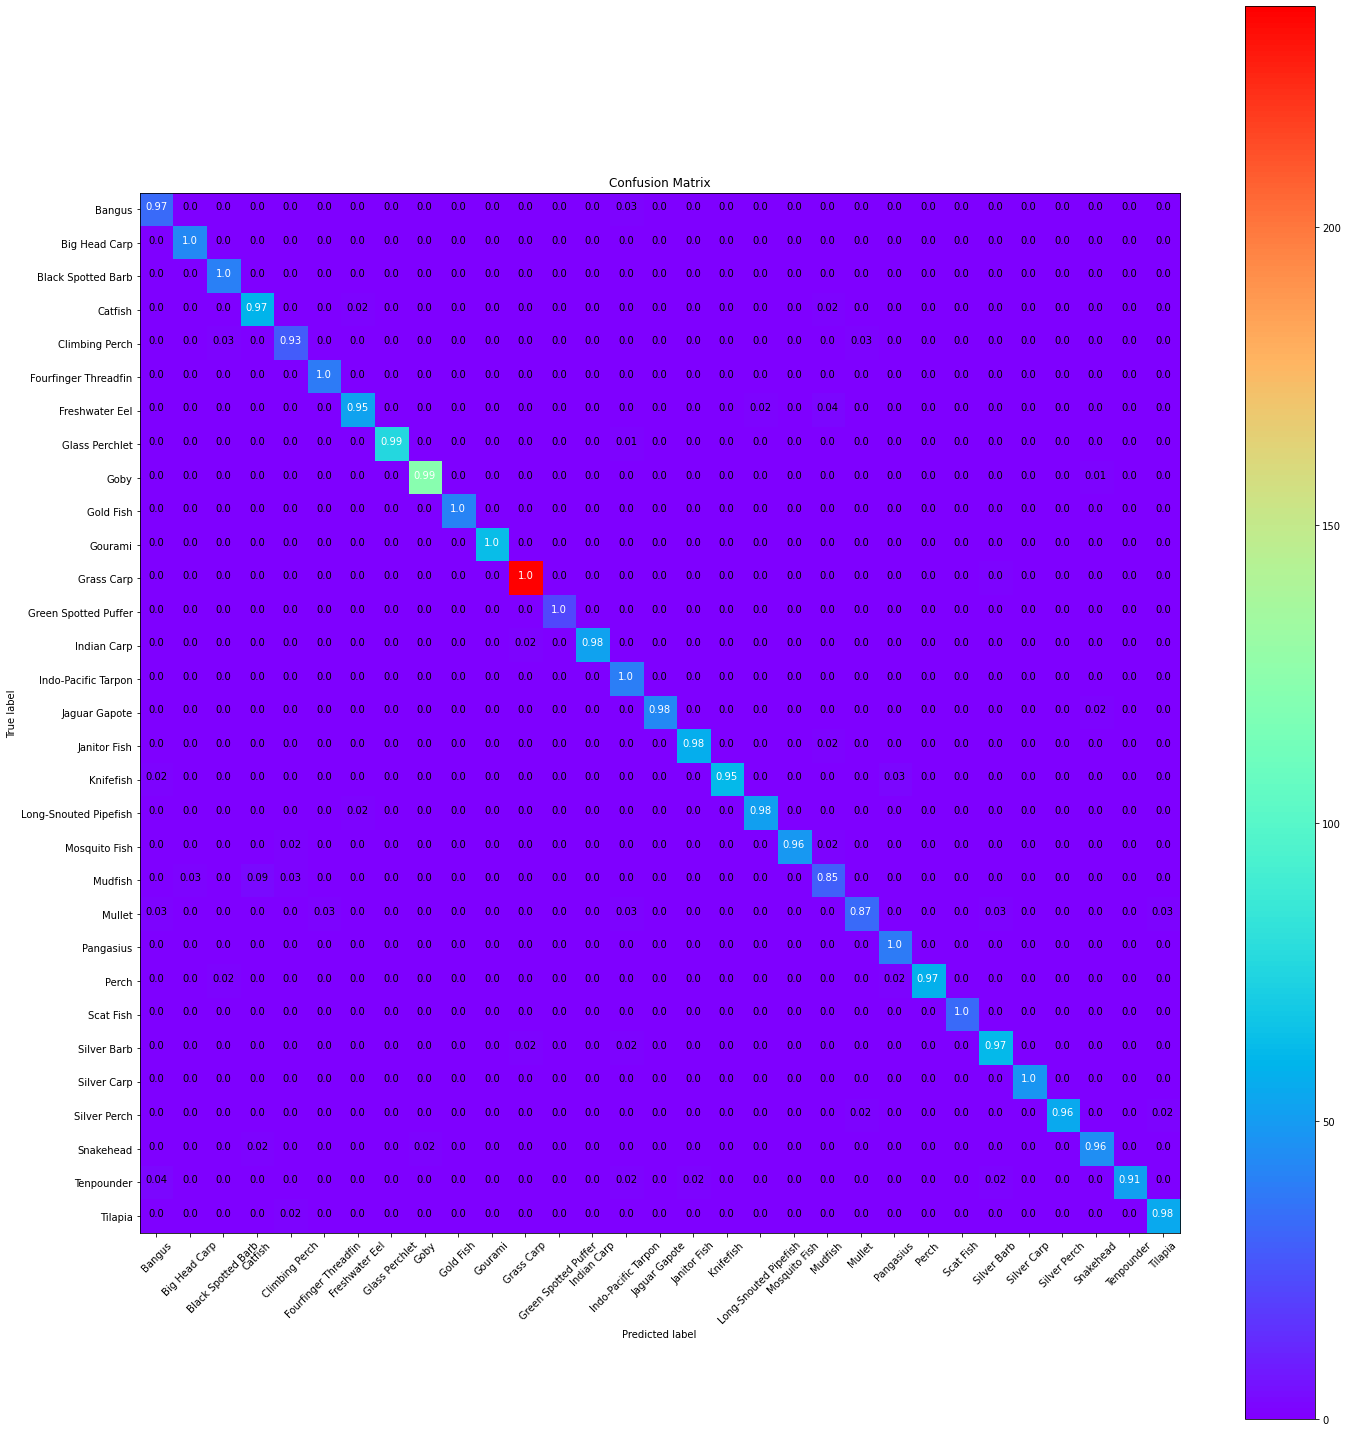

In [57]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='rainbow'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# **FINE TUNING OF MODEL**

In [ ]:
model.load_weights("./model_weights.h5")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



inception.trainable = False
for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="./FishModelClassifier.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate_reduction]


steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

In [ ]:
test_score = model.evaluate_generator(test_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

In [ ]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)